In [ ]:
pip install rdkit-pypi deepchem dgl

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Import all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from rdkit import Chem
from rdkit.Chem import Descriptors
from gensim.models import Word2Vec


In [ ]:
# Loading the dataset into a Pandas
dt = pd.read_csv('solubility.csv')
dt.head()

,Compound ID,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [ ]:
# Convert SMILES to lists of characters or tokens
smiles_list = dt['smiles'].apply(list).tolist()

# Generate molecular descriptors
def generate_descriptors(smiles):
  # Convert SMILES strings into RDKit molecular objects
    moldata = [Chem.MolFromSmiles(smile) for smile in smiles]
    descriptors = []

    # Loop through each molecure to calculate descriptors
    for mol in moldata:
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        row = [desc_MolLogP, desc_MolWt, desc_NumRotatableBonds]
        descriptors.append(row)

        # Convert the list of descriptors to a Pandas DataFrame
    return pd.DataFrame(descriptors, columns=["MolLogP", "MolWt", "NumRotatableBonds"])

df = generate_descriptors(dt['smiles'])

# Function to calculate the number of aromatic atoms in a molecule
def AromaticAtoms(m):
    aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    return sum(aromatic_atoms)

# Calculate the aromatic proportion for each molecule
mol_list = [Chem.MolFromSmiles(smile) for smile in dt['smiles']]
desc_AromaticProportion = [AromaticAtoms(mol)/Descriptors.HeavyAtomCount(mol) for mol in mol_list]
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=["AromaticProportion"])

# Combine the descriptors with the aromatic proportion
X_descriptors = pd.concat([df, df_desc_AromaticProportion], axis=1)



In [ ]:
# Initialize Word2Vec model
w2v_model = Word2Vec(smiles_list, vector_size=100, window=5, min_count=1, workers=4)

# Generate embeddings for each SMILES
def get_embeddings(smiles_list, model):
    embeddings = []
    for smile in smiles_list:
        smile_embeddings = [model.wv[char] for char in smile]
        avg_embedding = np.mean(smile_embeddings, axis=0)
        embeddings.append(avg_embedding)
    return np.array(embeddings)

smiles_embeddings = get_embeddings(smiles_list, w2v_model)

# Combine descriptors and embeddings
X_combined = np.hstack((X_descriptors, smiles_embeddings))

X_combined

array([[-3.10802000e+00,  4.57432000e+02,  7.00000000e+00, ...,
        -9.08319578e-02,  9.83935446e-02,  1.61504969e-01],
       [ 2.84032000e+00,  2.01225000e+02,  2.00000000e+00, ...,
        -1.18068196e-01, -3.68744582e-02,  3.08360234e-02],
       [ 2.87800000e+00,  1.52237000e+02,  4.00000000e+00, ...,
        -7.80469328e-02,  1.86277539e-01,  2.47734278e-01],
       ...,
       [ 2.99000000e+00,  2.46359000e+02,  7.00000000e+00, ...,
        -7.63187334e-02,  1.60514444e-01,  2.31069595e-01],
       [ 2.05240000e+00,  7.21510000e+01,  1.00000000e+00, ...,
        -7.93355331e-02,  2.07485124e-01,  2.64088780e-01],
       [ 5.60150000e+00,  3.65964000e+02,  5.00000000e+00, ...,
        -9.18568969e-02,  8.16554204e-02,  1.36298403e-01]])

In [ ]:
# Check for missing values
print(dt.isnull().sum())

# Handle missing values if any
dt = dt.dropna()

Compound ID                                  0
Minimum Degree                               0
Molecular Weight                             0
Number of H-Bond Donors                      0
Number of Rings                              0
Number of Rotatable Bonds                    0
Polar Surface Area                           0
measured log solubility in mols per litre    0
smiles                                       0
dtype: int64


In [ ]:
# Initializing the X variable while dropping the necessary columns
X = dt.drop(columns=[ 'Compound ID','measured log solubility in mols per litre'])
# Initializing the y (target) variable
y = dt.iloc[:,-2]

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X_combined,y, test_size=0.2,random_state=42 )


In [ ]:
# creating an instance of the RandomForestRegressor  with specific parameters
rfg = RandomForestRegressor(n_estimators=100,random_state=42, warm_start=True)

# Training the RandomForestRegressor on the training data
rfg.fit(X_train,y_train)

RandomForestRegressor(random_state=42, warm_start=True)

In [ ]:
#Make Predictions
y_pred = rfg.predict(X_test)

# Calculate the Metrics
mse = mean_squared_error(y_test,y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test,y_pred)

# Print the Metrics
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.6069709601008044
Root Mean Squared Error: 0.7790834102333359
R-squared: 0.8715895506443458


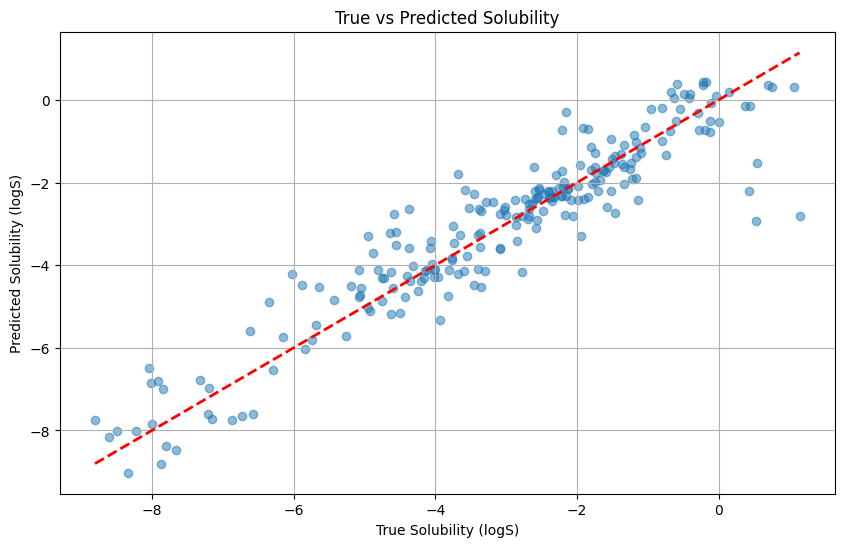

In [ ]:
# Scatter plot of true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Solubility (logS)')
plt.ylabel('Predicted Solubility (logS)')
plt.title('True vs Predicted Solubility')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.grid(True)
plt.show()

In [ ]:
# Print the first 5 lists of characters
print(smiles_list[:5])

[['O', 'C', 'C', '3', 'O', 'C', '(', 'O', 'C', 'C', '2', 'O', 'C', '(', 'O', 'C', '(', 'C', '#', 'N', ')', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', ')', 'C', '(', 'O', ')', 'C', '(', 'O', ')', 'C', '2', 'O', ')', 'C', '(', 'O', ')', 'C', '(', 'O', ')', 'C', '3', 'O', ' '], ['C', 'c', '1', 'o', 'c', 'c', 'c', '1', 'C', '(', '=', 'O', ')', 'N', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2'], ['C', 'C', '(', 'C', ')', '=', 'C', 'C', 'C', 'C', '(', 'C', ')', '=', 'C', 'C', '(', '=', 'O', ')'], ['c', '1', 'c', 'c', 'c', '2', 'c', '(', 'c', '1', ')', 'c', 'c', 'c', '3', 'c', '2', 'c', 'c', 'c', '4', 'c', '5', 'c', 'c', 'c', 'c', 'c', '5', 'c', 'c', 'c', '4', '3'], ['c', '1', 'c', 'c', 's', 'c', '1']]


In [ ]:
descriptor_columns = ['MolLogP', 'MolWt', 'NumRotatableBonds', 'AromaticProportion']
embedding_columns = [f'embedding_{i}' for i in range (smiles_embeddings.shape[1])]

# Combine descriptor and embedding columns
feature_importance = rfg.feature_importances_
feature_names = descriptor_columns + embedding_columns
importances = pd.Series(feature_importance, index=feature_names)

print(importances)

MolLogP               0.792407
MolWt                 0.097346
NumRotatableBonds     0.003472
AromaticProportion    0.000508
embedding_0           0.000456
                        ...   
embedding_95          0.002070
embedding_96          0.001608
embedding_97          0.001864
embedding_98          0.000141
embedding_99          0.000312
Length: 104, dtype: float64
